# K Means Clustering

## Submission by Ankan Kar (MCS202303) and Aman (MDS202305)

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import psutil
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from IPython.display import display

### Functions to read the file

In [2]:
def read_docword_matrix(file_path):
    with open(file_path, 'r') as file:
        for _ in range(3):
            next(file)

        data = [list(map(int, line.strip().split())) for line in file]

    max_doc_id = max(row[0] for row in data)
    max_word_id = max(row[1] for row in data)
    doc_term_matrix = np.zeros((max_doc_id, max_word_id), dtype=int)

    for doc_id, word_id, count in data:
        doc_term_matrix[doc_id - 1, word_id - 1] = 1

    return doc_term_matrix

def calculate_sparseness(matrix):
    total_elements = matrix.size
    non_zero_elements = np.count_nonzero(matrix)
    sparseness = 1.0 - (non_zero_elements / total_elements)
    return sparseness

### Jaccard Function

In [3]:
def jaccard_distance(a, b):
    intersection = np.sum(np.minimum(a, b))
    union = np.sum(np.maximum(a, b))
    return 1-(intersection / union)

In [4]:
def plot(data, centroids):
    plt.scatter(data[:, 0], data[:, 1], marker='.',
                color='gray', label='data points')
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1],
                color='black', label='previously selected centroids')
    plt.scatter(centroids[-1, 0], centroids[-1, 1],
                color='red', label='next centroid')
    plt.title('Select % d th centroid' % (centroids.shape[0]))

    plt.legend()
    plt.xlim(-5, 12)
    plt.ylim(-10, 15)
    plt.show()

### Function for KMeans Clustering

In [5]:
def initialize_centroids_1(data, k):
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]



def initialize_centroids(data, k):
    n_samples, n_features = data.shape
    centroids = np.empty((k, n_features))

    # Choose the first centroid randomly from the data points
    centroid_indices = [np.random.randint(n_samples)]
    centroids[0] = data[centroid_indices]

    # Calculate the pairwise Jaccard distances between the data points and the selected centroids
    distances = pairwise_distances(data, centroids[:1], metric=jaccard_distance).flatten()

    for i in range(1, k):
        # Select the next centroid with probability proportional to the squared distance
        prob = distances ** 2
        prob /= prob.sum()
        next_centroid_index = np.random.choice(n_samples, p=prob)
        centroids[i] = data[next_centroid_index]

        # Update the distances array with the minimum Jaccard distances to the new centroid
        new_distances = pairwise_distances(data, centroids[i:i+1], metric=jaccard_distance).flatten()
        distances = np.minimum(distances, new_distances)

    return centroids

In [6]:
def assign_clusters(data, centroids):
    distances = pairwise_distances(data, centroids, metric=jaccard_distance)
    return np.argmin(distances, axis=1)

In [7]:
def update_centroids(data, clusters, k, centroids=None):
    if centroids is None:
        centroids = initialize_centroids_1(data, k)
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        cluster_data = data[clusters == i]
        if len(cluster_data) > 0:
            new_centroids[i] = np.mean(cluster_data, axis=0)
        else:
            # If a cluster has no data points, use the corresponding centroid from K-means++
            new_centroids[i] = centroids[i]
    return new_centroids

In [8]:
def calculate_wcss(data, centroids, clusters):
    wcss = 0
    for i, centroid in enumerate(centroids):
        cluster_data = data[clusters == i]
        if len(cluster_data) > 0:
            wcss += np.sum(pairwise_distances(cluster_data, [centroid], metric=jaccard_distance)**2)
    return wcss

In [9]:
def mini_batch_kmeans(data, k, batch_size, max_iter, tol=1e-4):
    centroids = initialize_centroids(data, k)
    iteration = 0
    wcss_values = []

    while iteration < max_iter:
        batch_indices = np.random.choice(data.shape[0], batch_size, replace=False)
        batch_data = data[batch_indices]
        clusters = assign_clusters(batch_data, centroids)
        new_centroids = update_centroids(batch_data, clusters, k)
        wcss = calculate_wcss(batch_data, new_centroids, clusters)
        wcss_values.append(wcss)
        
        if np.sum(np.abs(new_centroids - centroids)) < tol:
            break
        
        centroids = new_centroids
        iteration += 1

    return wcss_values

In [10]:
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 

## Getting optimal K

### KOS Dataset

In [20]:
print("Number of Documents in kos dataset: ",len(read_docword_matrix('docword.kos.txt')))
print("Sparseness in kos dataset:", calculate_sparseness(read_docword_matrix('docword.kos.txt')))

Number of Documents in kos dataset:  3430
Sparseness in kos dataset: 0.9850909210649632


,Execution Time (s),Memory Usage (KB)
K,,
1,23.610894,172.000000
2,31.405819,16.000000
3,30.437374,12.000000
4,19.257064,972.000000
5,18.891693,1580.000000
6,27.843336,304.000000
7,21.520995,2004.000000
8,30.024552,12.000000
9,24.475059,2260.000000


Elbow point: 8


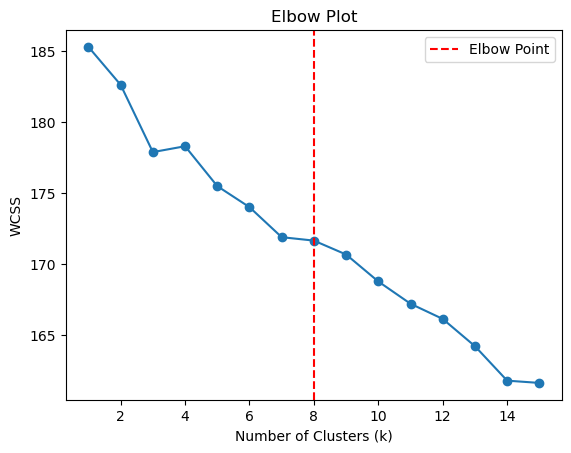

In [12]:
doc_term_matrix = read_docword_matrix('docword.kos.txt')

k_values = range(1, 16)

results = []

for k in k_values:
    start_time = time.time()
    start_memory = memory_usage()
    wcss = mini_batch_kmeans(doc_term_matrix, k, batch_size=200, max_iter=400, tol=1e-3)
    end_time = time.time()
    end_memory = memory_usage()
    
    execution_time = end_time - start_time
    memory_usage_diff = abs(end_memory - start_memory)
    
    results.append((k, execution_time, memory_usage_diff, wcss[-1]))

df = pd.DataFrame(results, columns=['K', 'Execution Time (s)', 'Memory Usage (KB)', 'WCSS'])

df.set_index('K', inplace=True)

df_subset = df.iloc[:, :2]

df_styled = df_subset.style.set_properties(**{'text-align': 'center'})

display(df_styled)

# Find the elbow point
diffs = np.diff(df['WCSS'])
diffs_ratio = diffs[1:] / diffs[:-1]
elbow_index = np.argmax(diffs_ratio) + 1
elbow_point = df.index[elbow_index]

# Display the results
print(f"Elbow point: {elbow_point}")

# Plot the WCSS plot
plt.plot(df.index, df['WCSS'], marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.axvline(x=elbow_point, color='r', linestyle='--', label='Elbow Point')
plt.legend()
plt.show()

In [24]:
print("The optimal value of k is ", elbow_point)

The optimal value of k is  8


### NIPS Dataset

In [19]:
print("Number of Documents in nips dataset: ",len(read_docword_matrix('docword.nips.txt')))
print("Sparseness in nips dataset:", calculate_sparseness(read_docword_matrix('docword.nips.txt')))

Number of Documents in nips dataset:  1500
Sparseness in nips dataset: 0.9599368709235848


,Execution Time (s),Memory Usage (KB)
K,,
1,105.687033,1936.000000
2,98.983267,8.000000
3,112.054239,1460.000000
4,128.698703,15096.000000
5,173.572351,1996.000000
6,190.030053,1984.000000
7,194.085378,76632.000000
8,201.917042,4328.000000
9,204.746158,31248.000000


Elbow point: 6


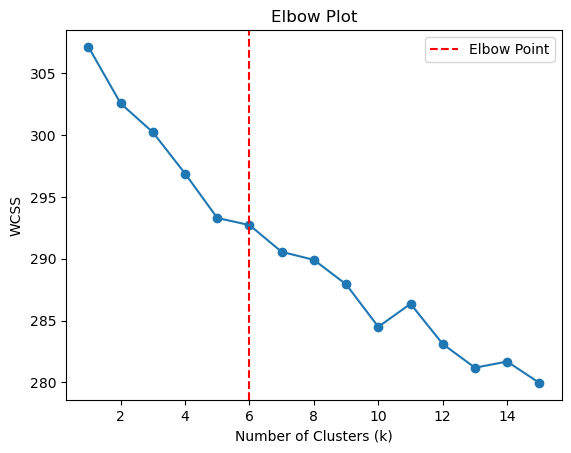

In [14]:
doc_term_matrix = read_docword_matrix('docword.nips.txt')

k_values = range(1, 16)

results = []

for k in k_values:
    start_time = time.time()
    start_memory = memory_usage()
    wcss = mini_batch_kmeans(doc_term_matrix, k, batch_size=400, max_iter=500, tol=1e-3)
    end_time = time.time()  
    end_memory = memory_usage()
    
    execution_time = end_time - start_time
    memory_usage_diff = abs(end_memory - start_memory)
    
    results.append((k, execution_time, memory_usage_diff, wcss[-1]))

df = pd.DataFrame(results, columns=['K', 'Execution Time (s)', 'Memory Usage (KB)', 'WCSS'])

# Set the 'K' column as the index
df.set_index('K', inplace=True)

# Select only the first two columns of the DataFrame
df_subset = df.iloc[:, :2]

df_styled = df_subset.style.set_properties(**{'text-align': 'center'})

display(df_styled)

# Find the elbow point
diffs = np.diff(df['WCSS'])
diffs_ratio = diffs[1:] / diffs[:-1]
elbow_index = np.argmax(diffs_ratio) + 1
elbow_point = df.index[elbow_index]

# Display the results
print(f"Elbow point: {elbow_point}")

# Plot the WCSS plot
plt.plot(df.index, df['WCSS'], marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.axvline(x=elbow_point, color='r', linestyle='--', label='Elbow Point')
plt.legend()
plt.show()  

In [23]:
print("The optimal value of k is ", elbow_point)

The optimal value of k is  6


### Enron Dataset

In [18]:
print("Number of Documents in enron dataset: ",len(read_docword_matrix('docword.enron.txt')))
print("Sparseness in enron dataset:", calculate_sparseness(read_docword_matrix('docword.enron.txt')))

Number of Documents in enron dataset:  39861
Sparseness in enron dataset: 0.996687639072501


,Execution Time (s),Memory Usage (KB)
K,,
1,109.790984,3282012.000000
2,185.456226,28868.000000
3,213.251746,33364.000000
4,266.202597,9160.000000
5,334.462179,764.000000
6,389.262424,1256.000000
7,459.330311,9500.000000
8,514.475751,6764.000000
9,566.775154,6240.000000


Elbow point: 6


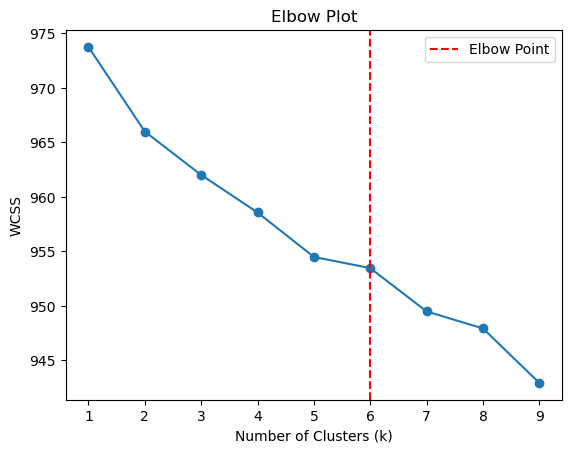

In [16]:
# Load the document-term matrix
doc_term_matrix = read_docword_matrix('docword.enron.txt')

# Define range of k values
k_values = range(1, 10)

# Initialize lists to store results
results = []

# Perform mini-batch K-means clustering for each k
for k in k_values:
    start_time = time.time()  # Record start time
    start_memory = memory_usage()  # Record start memory usage
    wcss = mini_batch_kmeans(doc_term_matrix, k, batch_size=1000, max_iter=100, tol=1e-2)
    end_time = time.time()  # Record end time
    end_memory = memory_usage()  # Record end memory usage
    
    execution_time = end_time - start_time
    memory_usage_diff = abs(end_memory - start_memory)
    
    results.append((k, execution_time, memory_usage_diff, wcss[-1]))  # Store the results

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['K', 'Execution Time (s)', 'Memory Usage (KB)', 'WCSS'])

# Set the 'K' column as the index
df.set_index('K', inplace=True)

# Select only the first two columns of the DataFrame
df_subset = df.iloc[:, :2]

df_styled = df_subset.style.set_properties(**{'text-align': 'center'})

display(df_styled)

# Find the elbow point
diffs = np.diff(df['WCSS'])
diffs_ratio = diffs[1:] / diffs[:-1]
elbow_index = np.argmax(diffs_ratio) + 1
elbow_point = df.index[elbow_index]

# Display the results
print(f"Elbow point: {elbow_point}")

# Plot the WCSS plot
plt.plot(df.index, df['WCSS'], marker='o')
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.axvline(x=elbow_point, color='r', linestyle='--', label='Elbow Point')
plt.legend()
plt.show()

In [25]:
print("The optimal value of k is ", elbow_point)

The optimal value of k is  6
